# Прогнозирование цен потребительского ритейла по тестовой выборке на основе глубоких нейронных сетей
__Выполнил:__ *Домченко Максим*

__Студент группы:__ *РИМ-130962*

In [2]:
# Подключение Google Drive
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')
ROOT = Path('/content/drive/MyDrive')

# Настройка структуры папок проекта
PROJECT_DIR = ROOT / 'price_forecasting'
DATA = PROJECT_DIR / 'data'
RAW = DATA / 'raw'
PROCESSED = DATA / 'processed'
MODELS = PROJECT_DIR / 'models'
MODELS.mkdir(exist_ok=True)

print('Проектная папка подключена:', PROJECT_DIR)

Mounted at /content/drive
Проектная папка подключена: /content/drive/MyDrive/price_forecasting


In [3]:
# Установка xgboost с поддержкой GPU
!pip install xgboost -U

# Импорт библиотек
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
import pickle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.4 MB/s eta 0:00:00


In [4]:
import xgboost as xgb

print(xgb.__version__)
print(xgb.build_info()['USE_CUDA'])  # Если True, то GPU поддерживается

3.0.2
True


In [5]:
# Загрузка подготовленных данных
train_df = pd.read_parquet(PROCESSED / 'train_features_final.parquet')
val_df = pd.read_parquet(PROCESSED / 'val_features_final.parquet')
test_df = pd.read_parquet(PROCESSED / 'test_features_final.parquet')

# Проверка загруженных данных
print(f"Размер тренировочной выборки: {train_df.shape}")
print(f"Размер валидационной выборки: {val_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")

display(train_df.head())

Размер тренировочной выборки: (35743638, 22)
Размер валидационной выборки: (5986318, 22)
Размер тестовой выборки: (6005441, 22)


,store_id,item_id,wm_yr_wk,sell_price,date,month,year,event_name_1,event_type_1,event_name_2,...,snap_TX,snap_WI,day_of_week,is_weekend,log_sell_price,event_flag,event_type_National,event_type_Cultural,event_type_Religious,event_type_Sporting
0,CA_1,FOODS_1_001,11101,2.0,2011-01-29,1,2011,NoEvent,NoEvent,NoEvent,...,0,0,5,1,1.098612,0,0,0,0,0
1,CA_1,FOODS_1_001,11101,2.0,2011-01-30,1,2011,NoEvent,NoEvent,NoEvent,...,0,0,6,1,1.098612,0,0,0,0,0
2,CA_1,FOODS_1_001,11101,2.0,2011-01-31,1,2011,NoEvent,NoEvent,NoEvent,...,0,0,0,0,1.098612,0,0,0,0,0
3,CA_1,FOODS_1_001,11101,2.0,2011-02-01,2,2011,NoEvent,NoEvent,NoEvent,...,1,0,1,0,1.098612,0,0,0,0,0
4,CA_1,FOODS_1_001,11101,2.0,2011-02-02,2,2011,NoEvent,NoEvent,NoEvent,...,0,1,2,0,1.098612,0,0,0,0,0


In [6]:
# Колонки для удаления (убираем лишние признаки и сохраняем таргеты отдельно)
cols_to_drop = ['date', 'wm_yr_wk', 'sell_price', 'log_sell_price']

# Извлечение таргета (цена и логарифм цены) отдельно
y_train = train_df[['sell_price', 'log_sell_price']]
y_val = val_df[['sell_price', 'log_sell_price']]
y_test = test_df[['sell_price', 'log_sell_price']]

# Удаление ненужных признаков из датасетов
X_train = train_df.drop(columns=cols_to_drop)
X_val = val_df.drop(columns=cols_to_drop)
X_test = test_df.drop(columns=cols_to_drop)

# Проверим итоговый состав признаков
print("Итоговый список признаков после финального обновления:")
for col in X_train.columns:
    print("-", col)

# Проверим итоговые датасеты
display(X_train.head())

Итоговый список признаков после финального обновления:
- store_id
- item_id
- month
- year
- event_name_1
- event_type_1
- event_name_2
- event_type_2
- snap_CA
- snap_TX
- snap_WI
- day_of_week
- is_weekend
- event_flag
- event_type_National
- event_type_Cultural
- event_type_Religious
- event_type_Sporting


,store_id,item_id,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_week,is_weekend,event_flag,event_type_National,event_type_Cultural,event_type_Religious,event_type_Sporting
0,CA_1,FOODS_1_001,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,5,1,0,0,0,0,0
1,CA_1,FOODS_1_001,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,6,1,0,0,0,0,0
2,CA_1,FOODS_1_001,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,0,0,0,0,0,0,0
3,CA_1,FOODS_1_001,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,1,0,1,0,0,0,0,0,0
4,CA_1,FOODS_1_001,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,0,1,2,0,0,0,0,0,0


In [7]:
# Кодирование категориальных признаков с помощью LabelEncoder
cat_features = ['store_id', 'item_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Проверим итог кодирования
display(X_train.head())

,store_id,item_id,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_week,is_weekend,event_flag,event_type_National,event_type_Cultural,event_type_Religious,event_type_Sporting
0,0,0,1,2011,19,2,3,1,0,0,0,5,1,0,0,0,0,0
1,0,0,1,2011,19,2,3,1,0,0,0,6,1,0,0,0,0,0
2,0,0,1,2011,19,2,3,1,0,0,0,0,0,0,0,0,0,0
3,0,0,2,2011,19,2,3,1,1,1,0,1,0,0,0,0,0,0
4,0,0,2,2011,19,2,3,1,1,0,1,2,0,0,0,0,0,0


In [8]:
# Создание DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [9]:
# Выбираем конкретный товар и магазин для прогноза
top_item_id = 'FOODS_1_129'
top_store_id = 'CA_1'

selected_df = pd.concat([train_df, val_df, test_df])
selected_df = selected_df[
    (selected_df['item_id'] == top_item_id) &
    (selected_df['store_id'] == top_store_id)
].copy()

selected_df.sort_values('date', inplace=True)

# Отделяем тестовый период
selected_test_df = selected_df[selected_df['date'] >= '2015-12-06'].copy()

# Готовим признаки для предсказания
cols_to_drop = ['date', 'wm_yr_wk', 'sell_price', 'log_sell_price']
selected_test_features = selected_test_df.drop(columns=cols_to_drop)

# Кодируем категориальные признаки с уже обученными энкодерами
for col in cat_features:
    selected_test_features[col] = label_encoders[col].transform(selected_test_features[col])

selected_test_features.head()

,store_id,item_id,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_week,is_weekend,event_flag,event_type_National,event_type_Cultural,event_type_Religious,event_type_Sporting
24822,0,126,12,2015,19,2,3,1,1,1,1,6,1,0,0,0,0,0
24823,0,126,12,2015,19,2,3,1,1,1,0,0,0,0,0,0,0,0
24824,0,126,12,2015,19,2,3,1,1,0,1,1,0,0,0,0,0,0
24825,0,126,12,2015,19,2,3,1,1,1,1,2,0,0,0,0,0,0
24826,0,126,12,2015,19,2,3,1,1,0,0,3,0,0,0,0,0,0


In [10]:
# Загружаем ранее обученную модель XGBoost
xgb_model = xgb.Booster()
xgb_model.load_model(MODELS / 'xgboost_model.json')

print('Модель успешно загружена.')

Модель успешно загружена.


In [11]:
# Создаем DMatrix для предсказания
dselected_test = xgb.DMatrix(selected_test_features)

# Выполняем прогноз (для обеих целевых переменных сразу)
y_pred = xgb_model.predict(dselected_test)

# Добавляем прогнозы в датафрейм отдельно
selected_test_df['sell_price_pred'] = y_pred[:, 0]
selected_test_df['log_sell_price_pred'] = y_pred[:, 1]

# Смотрим первые строки с прогнозами
selected_test_df[['date', 'log_sell_price', 'log_sell_price_pred']].head()

,date,log_sell_price,log_sell_price_pred
24822,2015-12-06,1.90806,1.377040
24823,2015-12-07,1.90806,1.376944
24824,2015-12-08,1.90806,1.376860
24825,2015-12-09,1.90806,1.376779
24826,2015-12-10,1.90806,1.376932


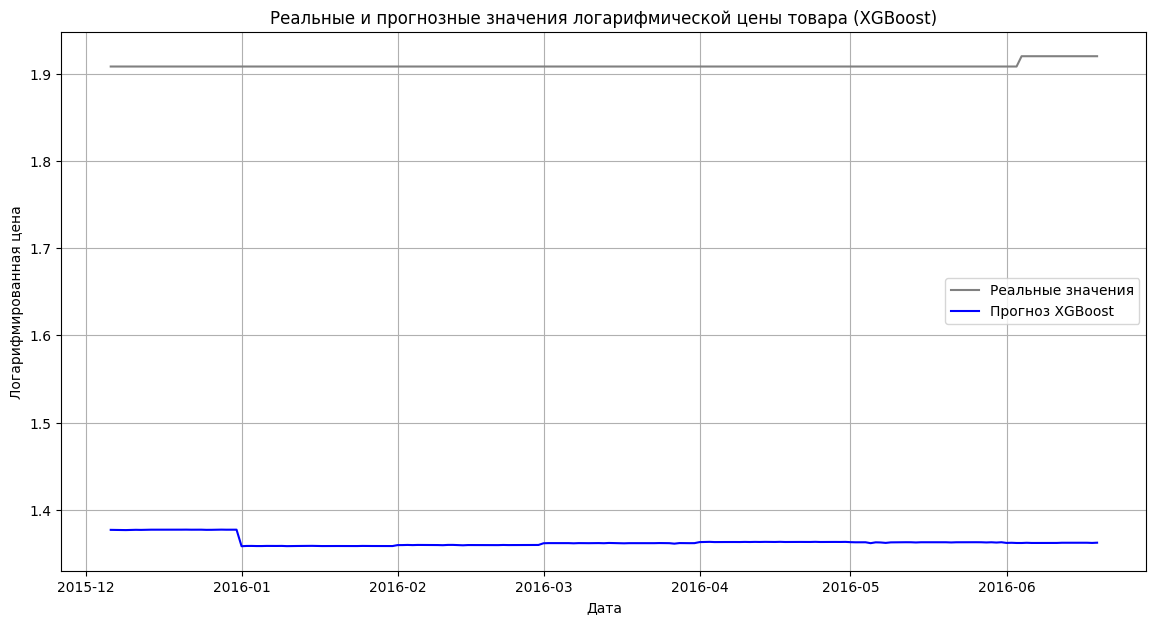

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Реальные значения логарифмированной цены
plt.plot(selected_test_df['date'], selected_test_df['log_sell_price'], label='Реальные значения', color='gray')

# Предсказанные значения логарифмированной цены
plt.plot(selected_test_df['date'], selected_test_df['log_sell_price_pred'], label='Прогноз XGBoost', color='blue')

plt.xlabel('Дата')
plt.ylabel('Логарифмированная цена')
plt.title('Реальные и прогнозные значения логарифмической цены товара (XGBoost)')
plt.legend()
plt.grid(True)

plt.show()

### Выводы по прогнозированию цены товара с помощью XGBoost

- Модель XGBoost была обучена для прогнозирования логарифмированных цен на конкретный товар.
- Реальные значения и прогноз XGBoost визуально значительно отличаются, что может быть связано с низкой изменчивостью цены этого товара в рассматриваемом периоде.
- Это может свидетельствовать о том, что модель с трудом улавливает тонкие колебания или неадекватно учитывает некоторые признаки (например, категориальные признаки или события).
- Для улучшения прогноза стоит рассмотреть дополнительную настройку гиперпараметров или проверку значимости отдельных признаков.
